### Machine Learning for Systems & Control 5SC27 2020-2021

sol_Exercise set W6 Reinforcement Learning Advanced.ipynb

# Exercise set W7  Actor-Critic methods

## Short Recap

This exercise set is based on the lecture, the book ''Reinforcement Learning, An Introduction second edition, by Richard S. Sutton and Andrew G. Barto for derivation'' and [Understanding Actor-Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f).

As seen in the lecture the *Actor* given by the stochastic policy function $\pi_{\theta}(u|x)$ and the *Critic* by $V_{\eta}(x)$. 

The **performance** of the actor is given by (which we want to maximize)

$$ J(\theta, x_t) = V_\theta(x_t) \\
= E \{ A_t \log(\pi_\theta(u_t|x_t)) \} \approx A_t \log(\pi_\theta(u_t|x_t))
$$ 

Which is defined in such a way that taking the gradient recovers the well known policy gradient 

$$
\nabla_\theta J(\theta, x_t) \approx A_t \nabla_\theta \log(\pi_\theta(u_t|x_t))
$$

with $A_t$ the advantage often given by the temporal difference (TD) $A_t = r_{t+1} + \gamma V_\eta(x_{t+1}) - V_\eta(x_t)$. The advantage interpreted as a measure for how much the perfomred action performed above expected performance (i.e. $A_t>0$ better than expected; $A_t<0$ worse than expected). 

The performance landscape can be visualized and the corresponding update rule by the following figure

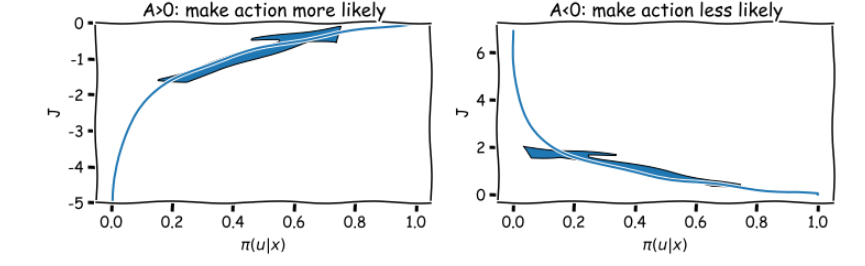

The update rule for the policy function is gradient **ascent**

$$\theta \leftarrow \theta + \alpha_a \nabla_\theta J(\theta, x_t)$$

where $\alpha_a$ is the stepsize for the policy gradient.

The value function is updated using a simple MSE **loss** of the following form 

$$L_{VF}(\eta) = \frac{1}{T} \sum_t \frac{1}{2} (V_{\eta}(x_t) - G_t)^2$$


with $G_t$ often chosen as $G_t = r_t + \gamma V_\eta(x_{t+1})$. This results in the following gradient **decent** step update.

$$\eta \leftarrow \eta - \alpha_c \nabla_\eta L_{VF}$$

and $\alpha_c$ the stepsize for the value function. For instance, in tabular learning this gradient for a given $x_t$ is

$$V(x_t) \leftarrow V(x_t) - \alpha_c (V(x_t) - (r_{t+1} + \gamma V(x_{t+1})) ) $$

### Exercise 0: Installations

**Run** the following cell to install all the modules needed for this exercise if you haven't already (`gym` for control problems, `Box2D` for some extra control problems, and `tqdm` for nice progress bars). If this installation fails open anaconda prompt in admin mode and use the same command `pip install gym Box2D tqdm` and afterwards restart the notebook. 

In [1]:
!pip install gym Box2D tqdm

### Exercise 1: Multi-armed Bandit  Actor-Critic solution

To get a grip on how the actor-critic method works implement actor-critic on the multi-armed bandit. 

**a)** Derive the update rule for the policy/actor $\pi_\theta(u)$ which maximizes the performance 

$$ J(\theta) = A_t \log(\pi_\theta(u))$$ 

 if the actor is the is given by the softmax 
 
 $$\pi_\theta(u) = \frac{\exp(\theta_u)}{\sum_k \exp(\theta_k)}$$
 
 with each $\theta_k$ a policy parameter corresponding to a certain discrete action.
 
**Answer a):**$$ \theta_i \leftarrow \theta_i + \alpha \frac{\partial}{\partial \theta_i} J\\     \theta_i \leftarrow \theta_i + \alpha \frac{\partial}{\partial \theta_i} log(\pi(u)) A_t \\     \theta_i \leftarrow \theta_i + \alpha \frac{\partial}{\partial \theta_i} (\theta_a - log(\sum_k \exp(\theta_k))) A_t \\     \theta_i \leftarrow \theta_i + \alpha (\delta_{ia} - \frac{\partial}{\partial \theta_i} log(\sum_k \exp(\theta_k))) A_t \\     \theta_i \leftarrow \theta_i + \alpha (\delta_{ia} - \frac{\exp(\theta_i)}{\sum_k \exp(\theta_k)}) A_t \\     \theta_i \leftarrow \theta_i + \alpha (\delta_{ia} - \pi(i)) A_t \\  $$  (where $\delta$ is the Kronecker delta defined by $\delta_{ia} = 1$ if $i=a$ else $0$)

**b)** Complete writing the softmax function below which is given by $\frac{\exp(\theta_a)}{\sum_k \exp(\theta_k)}$.
 
 *tip: use h-np.max(h) to ensure numerical stability* 
 
**c)** Start implemeting Actor-Critic by chosing an action according to the probabilities given by the policy of Actor as $$P(u)  = \pi_\theta(u) = \frac{\exp(\theta_u)}{\sum_k \exp(\theta_k)}$$ where $\theta$ is given by `Actor` in the code. Apply this randomly chosen action on the enviroment. 
 
 *tip: use `np.random.choise` using the `p` option to select an action and `bandit.step` to apply the action*
 
**d)** Calculate and apply the gradients of both the actor (`Actor`) and critic (`Critic`).
 
*tip: $V(x_{t+1}) = 0$ due to there being no internal state in the multi-armed bandit*
 
**e)** Set the step size of the critic to zero and observe the change in training speed and stability.

**Answer e):** The actor still converges to the correct action but it is much slower and less stable. 

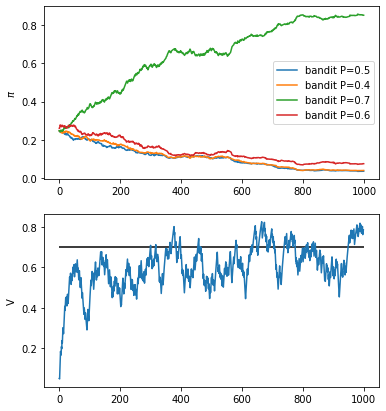

In [2]:
import numpy as np
import gym
from gym import spaces
from matplotlib import pyplot as plt


class Multiarmed_bandit(gym.Env):
    def __init__(self, P = [lambda k: 0.5, lambda k: 0.4, lambda k: 0.7, lambda k: 0.6]):
        self.P = P
        self.action_space = spaces.Discrete(len(self.P)) #u = 0, 1, ..., len(P)-1
        self.k = 0
    
    def step(self, u):
        Pnow = self.P[u] #select the uth element
        obs = None
        reward = int(np.random.rand()<Pnow(self.k)) #set reward to 1 if random uniform < P
        done = True #there is no memory in the system
        info = {} #almost never used
        self.k += 1
        return obs, reward, done, info

def softmax(h):
    hp = h-np.max(h) #b) #some addtional numerical stability.
    return np.exp(hp)/np.sum(np.exp(hp)) #b)

bandit = Multiarmed_bandit()
Nact = bandit.action_space.n
Actor = np.zeros((Nact,)) #init actor, (Theta)
actions = np.arange(Nact,dtype=int)
Critic = 0 #init critic
step_size_actor = 0.05 #alpha_a
step_size_critic = 0.05 #alpha_c
prob_hist = []
critic_hist = []

for i in range(1000):
    #take action
    probs = softmax(Actor) #c)
    action = np.random.choice(actions,p=probs) #c=)
    obs, reward, done, info = bandit.step(action) #c)
    
    #calculate gradients for both the actor and the critic:
    advantage = (reward-Critic) #d)
    tmp = np.zeros((Nact,)) #d)
    tmp[action] = 1 #d)
    grad_actor = (tmp-probs)*advantage #d)
    grad_critic = Critic-reward #d)
    
    #apply gradients:
    Actor += step_size_actor*grad_actor #d) #sign = + due to performance and thus ascent
    Critic -= step_size_critic*grad_critic #d) #sign! #sign = - due to loss and thus descent
    
    #save results:
    prob_hist.append(softmax(Actor)) #save the probability of choosing a certain action
    critic_hist.append(Critic) #save the critic value

plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plt.plot(prob_hist)
plt.ylabel(r'$\pi$')
plt.legend([f'bandit P={Pi(0)}' for Pi in bandit.P])
plt.subplot(2,1,2)
plt.plot(critic_hist)
plt.hlines(0.7,0,len(critic_hist))
plt.ylabel(r'V')
plt.show()

## Exercise 2: Actor-critic for discrete systems; A tabular solution

This exercise considers a discrete state/action system. The implementation is similar to the bandit of the previous exercise and we will be using the `FrozenLake-v0` gym environment [Docs](https://gym.openai.com/envs/FrozenLake-v0/)

**a)** For a discrate state (with $N_\text{states}$ states) and action enviroment (with $N_\text{actions}$ actions), what would be appropriate shapes of the parameters for the value function $V_\eta(x_t)$ and the policy function $\pi_\theta(u|x)$ (still given by a softmax).

**Answer a):** There are $N_\text{states}$ possible inputs to $V_\eta(x_t)$ hence it requires a shape of a vector with length $N_\text{states}$. For the policy function $\pi_\theta(u_t|x_t)$ there are $N_\text{states}$ by $N_\text{actions}$ possible inputs hence, we could take a matrix of shape ($N_\text{states}$ by $N_\text{actions}$). 

**b)** Pick an action according to the probability distrubution of the policy network $\pi_\theta(u|x)$ and calculate the advantage $A_t = G_t - V_\eta(x_t)$ with the returns $G_t$ defined as $G_t = r_{t+1} + \gamma V_\eta(x_{t+1})$

**c)** Calculate and apply the actor and critic gradients. 

*tip: you can copy from exercise 1*

*tip: update only the row of `Actor[obs_start]` and value of `Critic[obs_start]`*

  0%|          | 0/50000 [00:00<?, ?it/s]

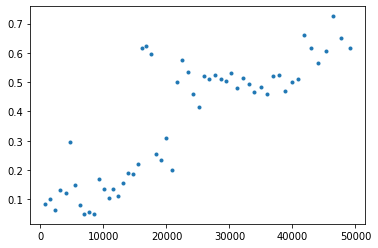

In [3]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
def eval_actor(Actor,env, deterministic=True):
    actions = np.arange(env.action_space.n,dtype=int)
    reward_acc = 0
    obs = env.reset()
    while True:
        action = np.argmax(Actor[obs]) if deterministic else np.random.choice(actions,p=softmax(Actor[obs_start]))
        obs, reward, done, info = env.step(action)
        reward_acc += reward
        if done:
            env.reset()
            return reward_acc
    
def softmax(h):
    hp = h-np.max(h)
    return np.exp(hp)/np.sum(np.exp(hp))

env = gym.make('FrozenLake-v0')
env.action_space,env.observation_space
Actor = np.zeros((env.observation_space.n, env.action_space.n)) #a=) #array of size (N states, N actions)
Critic = np.zeros((env.observation_space.n,)) #a=) array of size (N states,)
actions = np.arange(env.action_space.n,dtype=int)

obs_start = env.reset()
step_size_actor = 0.1
step_size_critic = 0.3
gamma = 0.95
rewards = []
index = []
it = 0
for i in tqdm(range(50000)):
    #take action
    probs = softmax(Actor[obs_start]) #b=)
    action = np.random.choice(actions,p=probs) #b=)
    
    obs_next, reward, done, info = env.step(action)
    terminal = done and not info.get('TimeLimit.truncated', False) #terminial state
    
    if terminal:
        returns = reward #b)
    else:
        returns = reward+gamma*Critic[obs_next] #b)
    
    advantage = (returns-Critic[obs_start]) #b=)
    
    tmp = np.zeros((env.action_space.n,)) #c)
    tmp[action] = 1 #c)
    grad_actor = (tmp-probs)*advantage #c)  
    grad_critic = -advantage #c) 
    
    Actor[obs_start] += step_size_actor*grad_actor #c)
    Critic[obs_start] -= step_size_critic*grad_critic #c)
    
    if done:
        it += 1
        if it%100==0:
            rewards.append(np.mean([eval_actor(Actor,env) for i in range(200)]))
            index.append(i)
        obs_start = env.reset()
    else:
        obs_start = obs_next
    
plt.plot(index,rewards,'.')
plt.show()

**d)** There are two ways to use the policy function $\pi_\theta(u|x)$ during evaluation.

 1. Take the most likely action $u = arg\max_u \pi_\theta(u|x)$
 2. or sample from the probability distrubution $u \sim \pi_\theta(u|x)$

It's dependent on the problem which approach works best. Evaluate this for this problem and reason about the result.

*tip: use the `deterministic` keyword in the `eval_actor` function*

In [4]:
print(np.mean([eval_actor(Actor, env, deterministic=True) for i in range(100)])) #d)
print(np.mean([eval_actor(Actor, env, deterministic=False) for i in range(100)])) #d)

0.64
0.01


**e)** Visulaize the policy.

In [5]:
obs = env.reset()
env.render()
while True:
    action = np.argmax(Actor[obs]) #e=)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
        env.close()
        break
    


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (U

## Exercise 3: The continuous multi-armed bandit

Let us consider that we do not have a finite number of multi-armed bandit but a continuous line. 

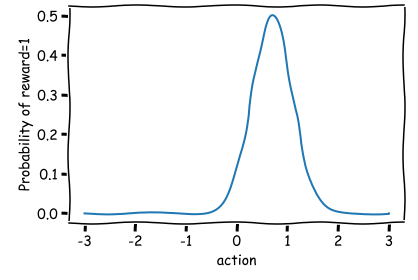

We want to train an agent such that it finds the action at $0.7$ which returns the highest expected reward.


For this problem, we can use Actor-Critic since it is capable to handle continuous action spaces (Actor-critic is most often used for its stability and ease of use). For instance, one can write the policy function as the probability density function of a fixed variance normal function as

$$ \pi_\theta (u|x) = \frac{1}{\sigma_u \sqrt{2 \pi}} \exp\left(-\frac{(\bar u_\theta(x)-u)^2}{2 \sigma_u^2} \right)$$

**a)** Derive the policy update rule for this form of the policy function using 

$$\theta \leftarrow \theta + \alpha_a \nabla_\theta J(\theta)$$

assuming that in the case of the multi-armed bandit that

$$\bar u_\theta(x) = \theta$$

with of course

$$ J(\theta) = A_t \log(\pi_\theta(u))$$ 

**Answer a):**$$ \log(\pi_\theta(u)) \sim -\frac{(\bar u_\theta(x)-u)^2}{2 \sigma_u^2} \text{   constants do not matter for the gradient} \\ \theta \leftarrow \theta + \alpha_a A_t \nabla_\theta -\frac{(\theta-u)^2}{2 \sigma_u^2} \\ \theta \leftarrow \theta + \alpha_a A_t \left (-\frac{\theta-u}{\sigma_u^2} \right) $$

**b)** Implement the Actor-critic approach for the continuous multi-armed bandit problem. 

*tip 1: use `np.random.normal` to sample for an action*

*tip 2: The Critic update and advantage is the same as exercise 1*

**c)** Re-run with different initial values of `Actor`=$\theta$ and formulate how they influence the resulting performance.

**Answer b):** If $\theta$ is too far from 0.7 then the agent will never see any rewards and hence change.

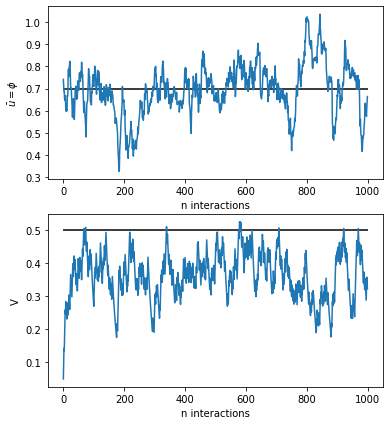

In [193]:
import numpy as np
import gym
from gym import spaces
from matplotlib import pyplot as plt

class Multiarmed_bandit_continues(gym.Env):
    def __init__(self, P = lambda action: np.exp(-1/2*(0.7-action)**2/0.4**2)*0.5):
        self.P = P
        l = np.array([-float('inf')]).astype(np.float32)
        self.action_space = spaces.Box(low=l,high=-l) #u = 0, 1, ..., len(P)-1

    
    def step(self, u):
        obs = None
        reward = int(np.random.rand()<self.P(u)) #set reward to 1 if random uniform < P
        done = True #there is no memory in the system
        info = {} #almost never used
        return obs, reward, done, info

bandit = Multiarmed_bandit_continues()
Actor = 0.7 #u mean
sigma_u = 0.3 #fixed std
Critic = 0
step_size_actor = 0.02
step_size_critic = 0.05
prob_hist = []
critic_hist = []

for i in range(1000):
    #take action
    action = np.random.normal(loc=Actor,scale=sigma_u) #b=)
    obs, reward, done, info = bandit.step(action)
    
    advantage = reward-Critic #b)
    
    grad_actor = -(Actor-action)/(sigma_u**2)*advantage #b)
    grad_critic = Critic-reward #b)
    
    Actor += step_size_actor*grad_actor #b=) ascent
    Critic -= step_size_critic*grad_critic #b=) decent

    prob_hist.append(Actor)
    critic_hist.append(Critic)

    
from matplotlib import pyplot as plt

plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plt.ylabel(r'$\bar u = \phi$')
plt.xlabel('n interactions')
plt.hlines(0.7,0,len(critic_hist))
plt.plot(prob_hist)
plt.subplot(2,1,2)
plt.plot(critic_hist)
plt.ylabel(r'V')
plt.xlabel('n interactions')
plt.hlines(bandit.P(0.7),0,len(critic_hist))
plt.show()

**d)** Up until now we enforced a fixed $\sigma_u$. However, $\sigma_u$ can also be introduced as a parameter which changes in the policy update step. Implement this new update rule below. 

**Answer d):** $$ \pi_\theta (u) = \frac{1}{\exp(\theta_2) \sqrt{2 \pi}} \exp\left(-\frac{(\theta_1-u)^2}{2 \exp(\theta_2)^2} \right)\\ \frac{\partial}{\partial \theta_1} \log \pi_\theta(u) = -\frac{\theta_1-u}{\sigma_u^2} \\ \frac{\partial}{\partial \theta_2} \log \pi_\theta(u) = \frac{(\theta_1-u)^2}{\sigma_u^2} - 1\\ $$

*tip: Write $\sigma_u = \exp(\theta_2)$ and $\bar u = \theta_1$ to ensure that $\sigma_u>0$.*

*tip: re-derive the policy update rule taking care of the normalization term of the normal distribution.*

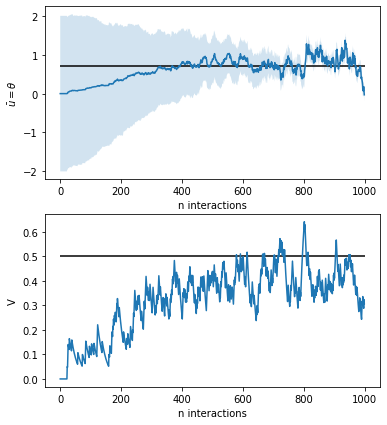

In [197]:
import numpy as np
import gym
from gym import spaces
from matplotlib import pyplot as plt

class Multiarmed_bandit_continues(gym.Env):
    def __init__(self, P = lambda action: np.exp(-1/2*(0.7-action)**2/0.4**2)*0.5):
        self.P = P
        l = np.array([-float('inf')]).astype(np.float32)
        self.action_space = spaces.Box(low=l,high=-l) #u = 0, 1, ..., len(P)-1

    
    def step(self, u):
        obs = None
        reward = int(np.random.rand()<self.P(u)) #set reward to 1 if random uniform < P
        done = True #there is no memory in the system
        info = {} #almost never used
        return obs, reward, done, info

bandit = Multiarmed_bandit_continues()
theta1 = 0 
theta2 = 0
Critic = 0
step_size_actor = 0.02
step_size_critic = 0.05
mean_u_hist = []
sigma_u_hist = []
critic_hist = []

for i in range(1000):
    #take action
    sigma_u = np.exp(theta2) #d=)
    action = np.random.normal(loc=theta1,scale=sigma_u)
    obs, reward, done, info = bandit.step(action)
    
    advantage = reward-Critic
    
    grad_actor_theta1 = -(theta1-action)/(sigma_u**2)*advantage #d=)
    grad_actor_theta2 = ((theta1-action)**2/(sigma_u**2) - 1)*advantage #d=)
    grad_critic = Critic-reward
    
    theta1 += step_size_actor*grad_actor_theta1 
    theta2 += step_size_actor*grad_actor_theta2 
    Critic -= step_size_critic*grad_critic 

    mean_u_hist.append(theta1)
    sigma_u_hist.append(np.exp(theta2))
    critic_hist.append(Critic)
mean_u_hist = np.array(mean_u_hist)
sigma_u_hist = np.array(sigma_u_hist)
    
from matplotlib import pyplot as plt

plt.figure(figsize=(6,7))
plt.subplot(2,1,1)
plt.ylabel(r'$\bar u = \theta$')
plt.xlabel('n interactions')
plt.hlines(0.7,0,len(critic_hist))
plt.plot(mean_u_hist)
plt.fill_between(np.arange(len(mean_u_hist)), mean_u_hist-2*sigma_u_hist, mean_u_hist+2*sigma_u_hist,alpha=0.2)
plt.subplot(2,1,2)
plt.plot(critic_hist)
plt.ylabel(r'V')
plt.xlabel('n interactions')
plt.hlines(bandit.P(0.7),0,len(critic_hist))
plt.show()

Text(0.5, 0, 'n interactions')

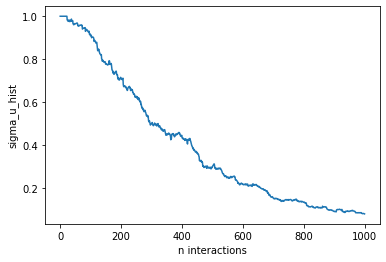

In [201]:
plt.plot(sigma_u_hist)
plt.ylabel('sigma_u_hist')
plt.xlabel('n interactions')

You might see in this exercise that $\sigma_u$ gets to small which results in no exploration. One popular way to limit this behaviour is to introduce an additional information entropy loss term which aught to be maximized (see: [Enptropy wiki](https://en.wikipedia.org/wiki/Entropy_(information_theory)) and [Differentail Entropy](https://en.wikipedia.org/wiki/Differential_entropy)). (e.g. maximize $S = \log (\sigma_u \sqrt{2 \pi e})$)

## Exercise 4: Actor-Critic Neural networks

In this exercise, you combine your knowledge of neural networks and the actor-critic method. We will consider the cart pole gym environment which has a discrete action space. This implementation employs many of the methods you saw in the previous exercise set where we implemented deep Q learning. This exercise implements the A2C algorithm. (Asynchronous, deterministic variant of Asynchronous Advantage Actor-Critic (A3C).)

**a)** Implement a neural network that implements an actor as
$$
\pi_\theta(.|x) = \text{softmax}(\text{ANN}(x))
$$
where the ANN has the same number of outputs actions, and a critic $$V_\eta(x)$$ which is a neural network with 1 output. Let both functions be parameterized as 1 hidden layer Neural Networks with tanh activations.

*tip: for numerical stability, we return `logp` if needed.*

In [218]:
import torch.nn as nn
import torch
import gym

class ActorCritic(nn.Module):
    def __init__(self, env, hidden_size=40):
        super(ActorCritic, self).__init__()
        num_inputs = env.observation_space.shape[0]
        num_actions = env.action_space.n

        #define your layers here:
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)  #a)
        self.critic_linear2 = nn.Linear(hidden_size, 1) #a)
        self.actor_linear1 = nn.Linear(num_inputs, hidden_size) #a)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions) #a)
    
    def actor(self, state, return_logp=False):
        #state has shape (Nbatch, Nobs)
        hidden = torch.tanh(self.actor_linear1(state)) #a)
        h = self.actor_linear2(hidden) #a=)
        h = h - torch.max(h,dim=1,keepdim=True)[0] #for additional numerical stability
        logp = h - torch.log(torch.sum(torch.exp(h),dim=1,keepdim=True)) #log of the softmax
        if return_logp:
            return logp
        else:
            return torch.exp(logp) #by default it will return the probability
    
    def critic(self, state):
        #state has shape (Nbatch, Nobs)
        hidden = torch.tanh(self.critic_linear1(state)) #a)
        return self.critic_linear2(hidden)[:,0] #a) #no activation function
    
    def forward(self, state):
        #state has shape (Nbatch, Nobs)
        return self.critic(state), self.actor(state)

env = gym.make('CartPole-v1')
actor_crit = ActorCritic(env, hidden_size=40)

obs = env.reset()
probs = actor_crit.actor(torch.as_tensor(obs,dtype=torch.float32)[None,:])[0] #call the actor
value = actor_crit.critic(torch.as_tensor(obs,dtype=torch.float32)[None,:])[0] #call the critic
print(f'value={value}')
print(f'probs={probs}') #sums to 1
pi = lambda x: actor_crit.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].detach().numpy() #shorthand
pi(obs)

value=0.24377338588237762
probs=tensor([0.5415, 0.4585], grad_fn=<SelectBackward>)


array([0.5415482, 0.4584518], dtype=float32)

**b)** Next, finish the implementation of the `rollout`, `eval_actor` and `show` function. In the rollout sample, the action distribution given by the actor. Whereas, for `eval_actor` and `show` functions the action is chosen which is most likely.

Start_state=[[ 3.42933493e-02  2.95058162e-02  3.44965308e-02 -3.56472002e-02]
 [ 3.48834657e-02  2.24116533e-01  3.37835868e-02 -3.17249632e-01]
 [ 3.93657963e-02  2.85300886e-02  2.74385941e-02 -1.41068862e-02]
 [ 3.99363981e-02 -1.66974402e-01  2.71564564e-02  2.87105398e-01]
 [ 3.65969101e-02 -3.62472895e-01  3.28985644e-02  5.88228030e-01]
 [ 2.93474522e-02 -5.58039733e-01  4.46631250e-02  8.91089986e-01]
 [ 1.81866575e-02 -7.53738235e-01  6.24849247e-02  1.19747160e+00]
 [ 3.11189280e-03 -9.49610738e-01  8.64343566e-02  1.50906559e+00]
 [-1.58803220e-02 -7.55636194e-01  1.16615668e-01  1.24457004e+00]
 [-3.09930458e-02 -9.52045081e-01  1.41507069e-01  1.57138973e+00]
 [-5.00339475e-02 -1.14854372e+00  1.72934864e-01  1.90465593e+00]
 [-2.19804132e-02  8.07514740e-03  4.14359134e-02  3.50934587e-02]
 [-2.18189103e-02  2.02579155e-01  4.21377826e-02 -2.44233453e-01]
 [-1.77673272e-02  3.97074701e-01  3.72531135e-02 -5.23332960e-01]
 [-9.82583313e-03  5.91653085e-01  2.67864544e-02 

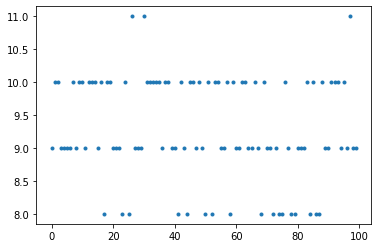

In [221]:
import time

def rollout(actor_crit, env, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    pi = lambda x: actor_crit.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        obs = env.reset() 
        for i in range(N_rollout): 
            action = np.random.choice(env.action_space.n,p=pi(obs)) #b=)

            Start_state.append(obs) 
            Actions.append(action)

            obs_next, reward, done, info = env.step(action)
            terminal = done and not info.get('TimeLimit.truncated', False)

            Terminal.append(terminal)
            Rewards.append(reward) 
            End_state.append(obs_next) 

            if done: 
                obs = env.reset() 
            else:
                obs = obs_next
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

def eval_actor(actor_crit, env):
    
    with torch.no_grad():
        rewards_acc = 0 
        obs = env.reset() 
        while True: 
            action = np.argmax(pi(obs)) #b=)
            obs, reward, done, info = env.step(action)
            rewards_acc += reward 
            if done: 
                return rewards_acc 

def show(actor_crit,env):
    pi = lambda x: actor_crit.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        try:
            obs = env.reset() 
            env.render() 
            time.sleep(1) 
            while True: 
                action = np.argmax(pi(obs)) #b=)
                obs, reward, done, info = env.step(action) 
                time.sleep(1/60) 
                env.render()
                if done: 
                    time.sleep(0.5) 
                    break  
        finally: #this will always run even when an error occurs
            env.close()


env = gym.make('CartPole-v1')
actor_crit = ActorCritic(env, hidden_size=40)

Start_state, Actions, Rewards, End_state, Terminal = rollout(actor_crit,env,N_rollout=20)
print(f'Start_state={Start_state}')
print(f'Actions={Actions}')
print(f'Rewards={Rewards}')
print(f'End_state={End_state}')
print(f'Terminal={Terminal}')
plt.plot([eval_actor(actor_crit, env) for i in range(100)],'.')
plt.show()
show(actor_crit,env)

**c)** Finish implementing the A2C algorithm seen below. Remeber that 

$$
A_t = TD = r_{t+1} + \gamma V_\eta(x_{t+1}) - V_\eta(x_{t})\\
L_{VF} = A_t^2\\
L_{pg} = - A_t \log(\pi_\theta(u_t|x)t)) \text{ where $A_t$ is excluded from the policy gradient}\\
L_{entropy} = -S = - \sum_u - \pi_\theta(u|x_t) \log(\pi_\theta(u|x_t))\\
L = L_{VF} + \alpha_a L_{pg} + \alpha_{\text{entropy}} L_{entropy}
$$

*tip: use `return_logp` for increased numerical stability*

*tip: use `.detach()` on $A_T$ calculating $L_{pg}$ to exclude it from the gradient calculation.*

*tip: do not forget the terminal state*

In [222]:
def A2C_rollout(actor_crit, optimizer, env, alpha_actor=0.5, alpha_entropy=0.5, gamma=0.98, \
                N_iterations=21, N_rollout=20000, N_epochs=10, batch_size=32, N_evals=10):
    best = -float('inf')
    torch.save(actor_crit.state_dict(),'actor-crit-checkpoint')
    try:
        for iteration in range(N_iterations):
            print(f'rollout iteration {iteration}')
            
            #2. rollout 
            Start_state, Actions, Rewards, End_state, Terminal = rollout(actor_crit, env, N_rollout=N_rollout)
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Terminal = convert([Start_state, Rewards, End_state, Terminal])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Terminal_batch = \
                    [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Terminal]]
                    
                    #Advantage:
                    Vnow = actor_crit.critic(Start_state_batch) #c=)
                    Vnext = actor_crit.critic(End_state_batch) #c=)
                    A = Rewards_batch + gamma*Vnext*(1-Terminal_batch) - Vnow #c=)
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0) #to filter actions
                    logp = actor_crit.actor(Start_state_batch,return_logp=True)[action_index] #c=)
                    p = torch.exp(logp) #c=)
                    
                    L_value_function = torch.mean(A**2) #c=)
                    L_policy = -(A.detach()*logp).mean() #c=) #detach A, the gradient should only to through logp
                    L_entropy = -torch.mean((-p*logp),0).sum() #c=) 
                    
                    Loss = L_value_function + alpha_actor*L_policy + alpha_entropy*L_entropy #c=) 
                    
                    optimizer.zero_grad()
                    Loss.backward()
                    optimizer.step()
                

                score = np.mean([eval_actor(actor_crit, env) for i in range(N_evals)])
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                print('\t Value loss:  ',L_value_function.item())
                print('\t Policy loss: ',L_policy.item())
                print('\t Entropy:     ',-L_entropy.item())
                
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving actor-crit... \n#################################')
                    torch.save(actor_crit.state_dict(),'actor-crit-checkpoint')
            
            print('loading best result')
            actor_crit.load_state_dict(torch.load('actor-crit-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        actor_crit.load_state_dict(torch.load('actor-crit-checkpoint'))

**d)** Use the `A2C` function to train an agent on the Cartpole enviroment. Tune and understand the hyperparameters. 

In [223]:
import torch
from torch import nn
import gym

env = gym.make('CartPole-v1')

gamma = 0.98 
batch_size = 32 
N_iterations = 5 
N_rollout = 20000 
N_epochs = 5 
N_evals = 10 
alpha_actor = 0.5
alpha_entropy = 0.5
#alpha_critic = 1 #fixed
lr = 0.005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
actor_crit = ActorCritic(env, hidden_size=40)
optimizer = torch.optim.Adam(actor_crit.parameters(), lr=lr) #low learning rate
A2C_rollout(actor_crit, optimizer, env, alpha_actor=alpha_actor, alpha_entropy=alpha_entropy,\
                         gamma=gamma, N_iterations=N_iterations, N_rollout=N_rollout, N_epochs=N_epochs, \
                         N_evals=N_evals)

rollout iteration 0
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: 96.7
	 Value loss:   0.7772555947303772
	 Policy loss:  0.4324265122413635
	 Entropy:      0.3096887469291687
################################# 
 new best 96.7 saving actor-crit... 
#################################
iteration=0 epoch=1 Average Reward per episode: 133.2
	 Value loss:   0.42665743827819824
	 Policy loss:  0.25532442331314087
	 Entropy:      0.2867429256439209
################################# 
 new best 133.2 saving actor-crit... 
#################################
iteration=0 epoch=2 Average Reward per episode: 244.2
	 Value loss:   0.3339764475822449
	 Policy loss:  0.2286721020936966
	 Entropy:      0.26807379722595215
################################# 
 new best 244.2 saving actor-crit... 
#################################
iteration=0 epoch=3 Average Reward per episode: 157.6
	 Value loss:   0.31282761693000793
	 Policy loss:  0.29416829347610474
	 Entropy: 

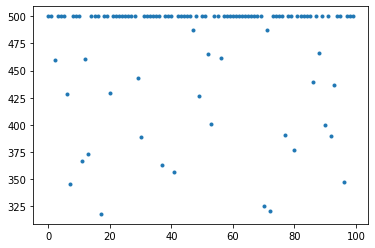

In [12]:
plt.plot([eval_actor(actor_crit, env) for i in range(100)],'.')
plt.show()
show(actor_crit,env)

## Exercise 5: Neural Network Actor-Critic


In practical applications of RL, one would not implement the RL algorithm themself but use an open-source library. For model-free neural network-based approaches I recommend using [Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/guide/rl.html). 

**Run** the next cell to install it. see: [install guide](https://stable-baselines3.readthedocs.io/en/master/guide/install.html) for more information.

In [1]:
!pip install cloudpickle stable-baselines3[extra] --no-deps

**a)** Run the cart pole example using the A2C algorithm. (A synchronous, deterministic variant of Asynchronous Advantage Actor-Critic (A3C).)
https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html

In [225]:
import gym
import numpy as np

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init


env_id = "Pendulum-v0"
num_cpu = 4  # Number of processes to use
# Create the vectorized environment
env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

# Stable Baselines provides you with make_vec_env() helper
# which does exactly the previous steps for you:
# env = make_vec_env(env_id, n_envs=num_cpu, seed=0)

model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=25000)

obs = env.reset()
try:
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()
finally:
    env.close()


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 2132     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0.0334   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -26.1    |
|    std                | 0.985    |
|    value_loss         | 714      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 2193     |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 4000     |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | 0.573    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss     

**b)** Re-run with `Pendulum-v0` and `LunarLander-v2` and observe results.

**c)** Run with a different algorithm such as `PPO`. https://arxiv.org/pdf/1707.06347.pdf